In [140]:
import scipy.io
import numpy as np
import pandas as pd
import os
import time
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# File paths -> needs to be adjusted
cap_data_path = "capture_data/"
cap_file_names = ["S16_E" + str(i) for i in range(1, 5)]

# load data from .mat-file and get it into nicer data structure
selected_recording = 4 ##### Here you can change the recording
rec1 = scipy.io.loadmat(cap_data_path + cap_file_names[selected_recording-1] + ".mat")[cap_file_names[selected_recording-1]]
frame_count = rec1['Frames'][0][0][0][0]
fs = rec1['FrameRate'][0][0][0][0]
start_time = rec1['Timestamp'][0][0][0]

# explanation for the labels
labels = [l[0] for l in rec1['Trajectories'][0][0][0][0][0][0][0][1][0]]
labels_explanation = {"HEE": "Ferse", "MAN": "Sprunggelenk Knöchel innen", "ANK": "Sprunggelenk Knöchel außen",
                     "MT1": "Gelenk des großen Fußzehs", "TOE": "Zeh", "KNE": "Knie (außen)", "MKN": "Knie innen",
                     "HIP": "Hüfte", "PSI": "hinterer Beckenkamm", "ASI": "vorderer Beckenkamm",
                     "SHO": "Schulter", "C7": "siebter Dornfortsatz des Halswirbels",
                     "Lever": "Umlenkarme am Knie -> pro Knie links und rechts", 
                     "HAM": "Feder auf der Rückseite, pro Bein unten und oben", 
                     "Brace": "Gurt vorne am Bein"}
# new labels for any recording past the first:
# 'LLeverL', 'LLeverR', 'RLeverL', 'RLeverR', 'LHAML', 'LHAMhigh', 'RHAMlow', 'RHAMhigh', 'RBrace', 'LBrace', 'RRFhigh', 'RRFlow', 'LRFhigh', 'LRFlow'
# Missing Labels for any recording past the first: 'LMKN', 'RMKN'

# setting necessary connections for a nice drawing; dependet on the measurement
connection_dict1 = {'RKNE': [2, ['RHIP', 'RANK']], 'RTOE': [3, ['RMT1', 'RANK']], 'LASI': [4, ['LPSI', 'LHIP', 'LSHO','RASI']],
                    'C7': [5, ['RSHO', 'LSHO']], 'LMT1': [7, ['LMAN']], 'RASI': [10, ['RPSI', 'RHIP', 'RSHO']], 'RMT1': [12, ['RMAN']],
                    'LKNE': [13, ['LHIP', 'LANK']], 'LMKN': [14, ['LPSI','LMAN']], 'LTOE': [19,['LMT1', 'LANK']],
                    'RHEE': [20, ['RMAN', 'RANK']], 'LHEE': [21, ['LMAN', 'LANK']], 'RMKN': [22, ['RPSI', 'RMAN']]}
connection_indices1 = [2,3,4,5,7,10,12,13,14,19,20,21,22]
connection_dict2 = {'RKNE': [2, ['RLeverR', 'RHIP', 'RANK', 'RBrace']], 'RTOE': [3, ['RMT1', 'RANK']], 
                    'LASI': [4, ['LPSI', 'LHIP', 'LSHO','RASI']], 'C7': [5, ['RSHO', 'LSHO']], 'LMT1': [7, ['LMAN']], 
                    'RASI': [11, ['RPSI', 'RHIP', 'RSHO']], 'RMT1': [13, ['RMAN']], 
                    'LKNE': [15, ['LLeverL', 'LHIP', 'LANK', 'LBrace']], 'RHAMhigh': [16, ['RHAMlow', 'RRFhigh']], 
                    'LLeverR': [19, ['LLeverL', 'LMAN','LPSI', 'LBrace']], 
                    'RLeverL': [21, ['RLeverR', 'RMAN','RPSI', 'RBrace']], 
                    'LTOE': [24,['LMT1', 'LANK']], 'RHEE': [25, ['RMAN', 'RANK']], 'LHEE': [26, ['LMAN', 'LANK']], 
                    'LHAMhigh': [29, ['LHAML','LRFhigh']], 'RRFlow': [32, ['RHAMlow', 'RRFhigh']], 
                    'LRFlow': [34,['LHAML', 'LRFhigh']]}
connection_indices2 = [2,3,4,5,7,11,13,15,16,19,21,24,25,26,29,32,34]

label_connection_table = pd.DataFrame(0, index=labels, columns=labels)
if selected_recording == 1:
    connection_dict = connection_dict1
    connection_indices = connection_indices1
else:
    connection_dict = connection_dict2
    connection_indices = connection_indices2
    
for k in connection_dict.keys():
    label_connection_table.iloc[connection_dict[k][0]][connection_dict[k][1]] = 1

connections = []
for i in connection_indices:
    connections.append(list(label_connection_table[label_connection_table.iloc[i]==1].index))

trajectories = rec1['Trajectories'][0][0][0][0][0][0][0][2]
not_missing = rec1['Trajectories'][0][0][0][0][0][0][0][3]

x_data = pd.DataFrame(trajectories[:,0,:].T, columns = labels)
y_data = pd.DataFrame(trajectories[:,1,:].T, columns = labels)
z_data = pd.DataFrame(trajectories[:,2,:].T, columns = labels)
c_data = pd.DataFrame(trajectories[:,3,:].T, columns = labels)


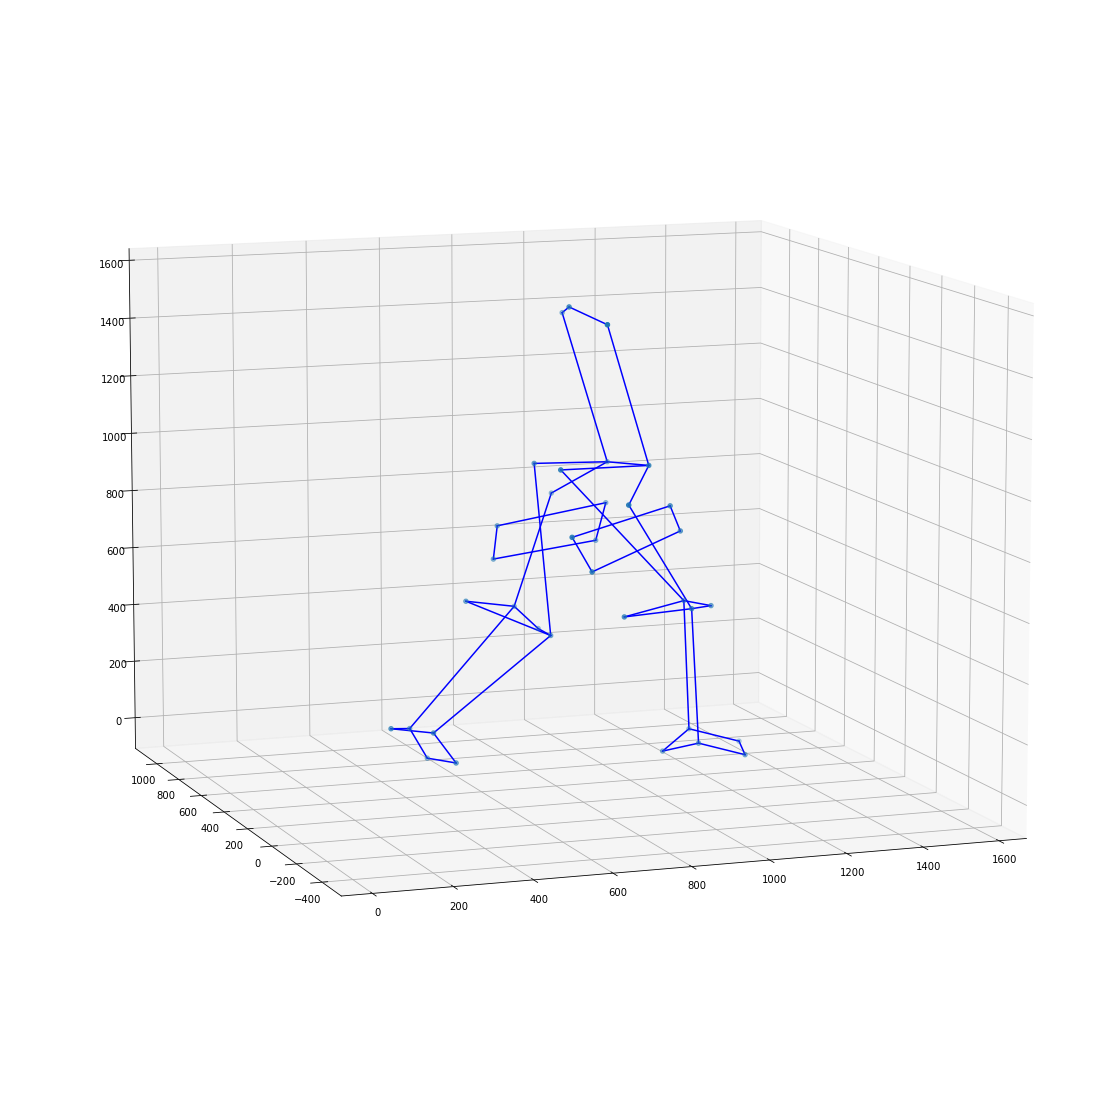

In [141]:
# plots a still frame of the motion in 3d coordinates

# define function for nice drawing
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


# create figure, make it look nice
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.azim = -110
ax.elev = 10

# select frame, get data # 24460 -> 3743
frame = 24660 # Erste Aufnahme: 24976
x0 = x_data.iloc[frame]
y0 = y_data.iloc[frame]
z0 = z_data.iloc[frame]

# make a scatter plot of the joints
ax.scatter(x0,y0,z0)

# plot connections, not just single points
counter = 0
for j in connection_dict.keys():
    for i in connections[counter]:
        ax.plot([x0[j], x0[i]], [y0[j], y0[i]],zs=[z0[j], z0[i]],c='b')
    counter +=1

set_axes_equal(ax)
plt.show()


In [146]:
if selected_recording == 1:
    # Writing down the coordinates of the 2d plane in homogeneous coordinates:
    used_labels = ['RTOE', 'LTOE', 'RKNE', 'LKNE', 'RHIP', 'LHIP', 'RASI', 'LASI', 'RSHO', 'LSHO']

    # These coordinates have been found by hand, do not change!
    # Frame 9132 ^=^ 24576:
    points_2d_9132 = np.array([[1083,1244,4/3],[1283,1172,4/3],[1102,935,4/3],[1277,932,4/3],
                               [1086,690,4/3],[1298,713,4/3],[1128,610,4/3],[1278,627,4/3],
                               [1111,356,4/3],[1308,374,4/3]])
    # Frame 9282 ^=^ 25576:
    points_2d_9282 = np.array([[1126,1255,4/3],[1312,1239,4/3],[1144,904,4/3],[1325,920,4/3],
                               [1136,657,4/3],[1355,678,4/3],[1180,568,4/3],[1346,581,4/3],
                               [1147,282,4/3],[1373,301,4/3]])
    # Frame 17952 ^=^ 83376:
    points_2d_17952 = np.array([[1106,1261,4/3],[1313,1253,4/3],[1135,910,4/3],[1321,925,4/3],
                                [1129,653,4/3],[1348,696,4/3],[1178,565,4/3],[1344,582,4/3],
                                [1150,279,4/3],[1382,298,4/3]])

    # concatenating and resizing from 2560x1440 to 1920x1080
    points_2d = np.concatenate((points_2d_9132,points_2d_9282,points_2d_17952),axis=0)*3/4

    # getting the 3d-coordinates for points 0 to 9 as defined in the pictures
    # select frames, get data
    frames = [24576, 25576, 83376]
    cache = []
    for f in frames:
        xs = x_data.iloc[f]
        ys = y_data.iloc[f]
        zs = z_data.iloc[f]
        cache.append(np.stack((xs[used_labels],ys[used_labels],zs[used_labels],np.ones(10)),axis=1))
    points_3d = np.concatenate(cache, axis=0)
    
if selected_recording == 4:
    # Writing down the coordinates of the 2d plane in homogeneous coordinates:
    used_labels1 = ['RTOE', 'RHEE', 'RBrace', 'RPSI', 'LPSI', 'RSHO', 'LHAML']
    used_labels2 = ['LANK', 'RHEE', 'RBrace', 'LLeverR', 'LPSI', 'RSHO', 'LHAML']
    used_labels3 = ['LANK', 'RHEE', 'RBrace', 'RPSI', 'LBrace', 'RSHO', 'RHAMlow']
    used_labels = [used_labels1, used_labels2, used_labels3]

    # Frame 3743 ^=^ 24460:
    points_2d_3743 = np.array([[999,1230,4/3],[854,1190,4/3],[927,843,4/3],[955,501,4/3],
                               [916,521,4/3],[1101,199,4/3],[890,744,4/3]])
    # Frame 3773 ^=^ 24660::
    points_2d_3773 = np.array([[706,1137,4/3],[1110,1193,4/3],[1036,868,4/3],[914,919,4/3],
                               [902,557,4/3],[1036,221,4/3],[834,756,4/3]])
    # Frame 7258 ^=^ 47893:
    points_2d_7258 = np.array([[1139,1153,4/3],[606,1113,4/3],[794,821,4/3],[919,537,4/3],
                                [983,908,4/3],[1060,231,4/3],[841,713,4/3]])

    # concatenating and resizing from 2560x1440 to 1920x1080
    points_2d = np.concatenate((points_2d_3743,points_2d_3773,points_2d_7258),axis=0)*3/4

    # getting the 3d-coordinates for points 0 to 9 as defined in the pictures
    # select frames, get data
    frames = [24460, 24660, 47893]
    count = 0
    cache = []
    for f in frames:
        xs = x_data.iloc[f]
        ys = y_data.iloc[f]
        zs = z_data.iloc[f]
        cache.append(np.stack((xs[used_labels[count]],ys[used_labels[count]],zs[used_labels[count]],np.ones(7)),axis=1))
        count += 1
    points_3d = np.concatenate(cache, axis=0)

In [155]:
import cv2

input_2d = np.array([points_2d[i,0:2] for i in range(len(points_2d))])
input_3d = np.array([points_3d[i,0:3] for i in range(len(points_3d))])
dist_coeffs = np.zeros((4,1))

def res(param):
    global points_2d
    global dist_coeffs
    global input_3d
    r, t, i = intr_cam_mat_mul(param)
    output_2d,_ = cv2.projectPoints(input_3d,r,t,i,dist_coeffs)
#     result = intr_cam_mat_mul(param)
    result = np.hstack((output_2d.squeeze(),ones((input_3d.shape[0],1))))
    error = np.sum((points_2d-result)**2,axis=1)
    return error

def intr_cam_mat_mul(param):
    global T2
    global input_2d
    global input_3d
    global dist_coeffs
    f = param[0]
    px = param[1]
    py = param[2]
    intr_cam_mat = np.array([[f,0,px],[0,f,py],[0,0,1]]).astype('float')
    _,rotation_vector,translation_vector = cv2.solvePnP(input_3d, input_2d, intr_cam_mat, dist_coeffs,flags=0)
#     output_2d,_ = cv2.projectPoints(input_3d,rotation_vector,translation_vector,intr_cam_mat,dist_coeffs)
    return rotation_vector, translation_vector, intr_cam_mat # np.hstack((output_2d.squeeze(),ones((30,1)))) # 

from scipy.optimize import least_squares

param_start = [1920, 960, 540]

result = least_squares(res, param_start, method='lm')
l, m, a = intr_cam_mat_mul(result.x)

# fin,_ = cv2.projectPoints(input_3d,l,m,a,dist_coeffs)

# fin.squeeze()

In [156]:
# transforming all points and saving the transformation to a numpy-file

all_points_3d = [np.array([x_data.iloc[n],y_data.iloc[n],z_data.iloc[n]]).transpose() for n in range(x_data.shape[0])]
all_points_2d = np.array([cv2.projectPoints(all_points_3d[n],l,m,a,dist_coeffs)[0].squeeze() for n in range(len(all_points_3d))])
np.save('2d_transformed_ground_truth_2.npy',all_points_2d)

Percent done: 0.0
Percent done: 0.0
Percent done: 6.0
Percent done: 12.0
Percent done: 18.0
Percent done: 24.0
Percent done: 30.0
Percent done: 36.0
Percent done: 42.0
Percent done: 48.0
Percent done: 54.0
Percent done: 60.0
Percent done: 66.0
Percent done: 72.0
Percent done: 78.0
Percent done: 84.0
Percent done: 90.0
Percent done: 96.0
909.2420635223389


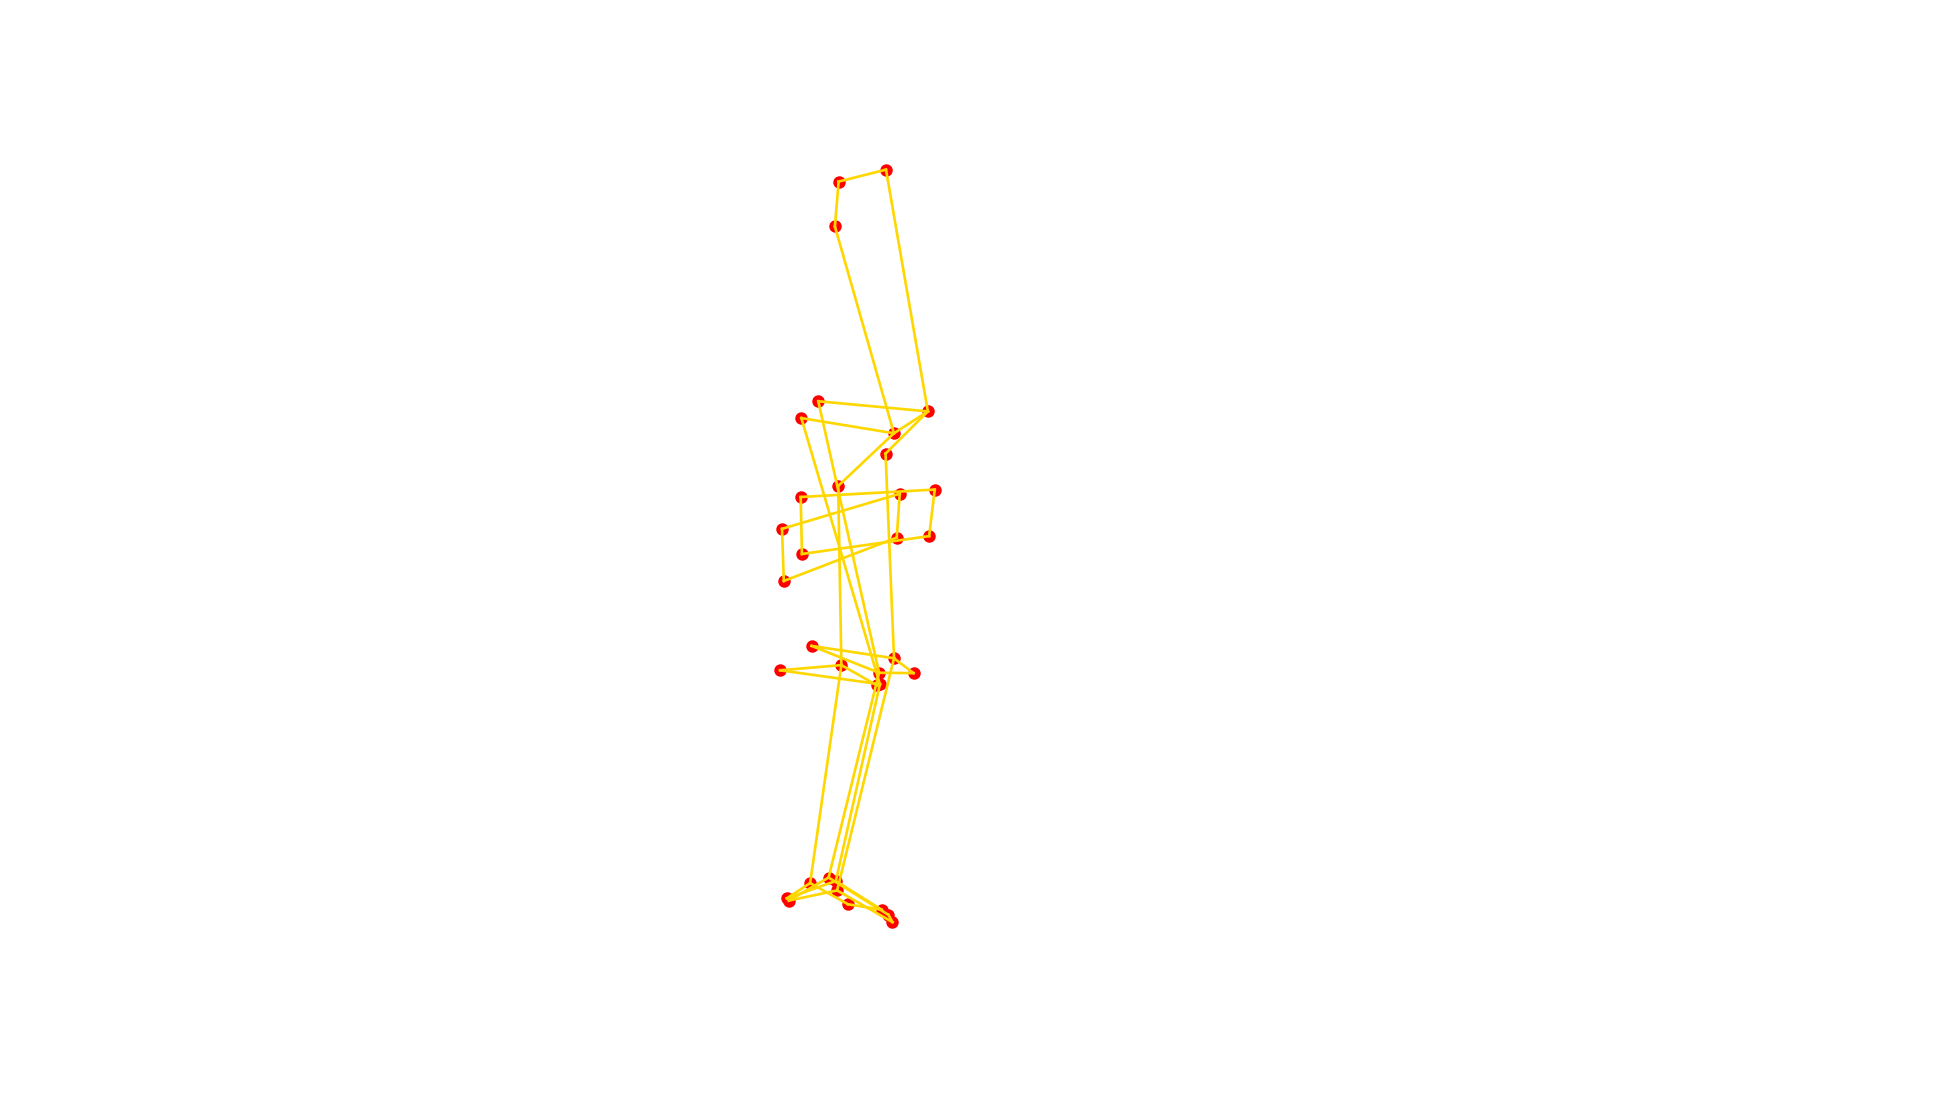

In [160]:
# video in correct perspective -> only relevant if you want to create a new video
           
dpi = 128
start = 0

if selected_recording == 1:
    start_frame = 23376
elif selected_recording == 4:
    start_frame = 24060 # ^=^ 3683

def ani_frame_2d():
    px = 1/plt.rcParams['figure.dpi']
    vid = plt.figure(figsize=(15,8.4375),dpi=128,frameon=False)
    ax0 = plt.Axes(vid, [0., 0., 1., 1.])
    ax0.set_axis_off()
    vid.add_axes(ax0)
    ax0.axis(xmin = 0, xmax = 1920)
    ax0.axis(ymin = 0, ymax = 1080)
    ax0.azim = 0
    ax0.elev = 0
    ax0.axis('off')

    x_0 = x_data.iloc[start]
    y_0 = y_data.iloc[start]
    z_0 = z_data.iloc[start]
    
    p = np.array([x_data.iloc[start],y_data.iloc[start],z_data.iloc[start]]).transpose()
    temp,_ = cv2.projectPoints(p,l,m,a,dist_coeffs)
    p_2d = temp.squeeze().T
    ax0.scatter(p_2d[0,:],1080-p_2d[1,:])
    ax0.plot([0,1920],[1,1],c='r')

    # eigentlich: 200 fps, jetzt 33,333 fps -> jedes 6. Bild
    
    def update_img_2d(n):
        p_tmp = np.array([x_data.iloc[n],y_data.iloc[n],z_data.iloc[n]]).transpose()
        temp,_ = cv2.projectPoints(p_tmp,l,m,a,dist_coeffs)
        p_2d_tmp = temp.squeeze()
        
        ax0.clear()
        ax0.axis(xmin = 0, xmax = 1920)
        ax0.axis(ymin = 0, ymax = 1080)
        ax0.axis('off')
        ax0.scatter(p_2d_tmp[:,0],1080-p_2d_tmp[:,1],c='r')
                
        counter = 0
        connect_col_indices = [labels.index(i) for i in connection_dict.keys()]
        for j in connect_col_indices:
            for i in connections[counter]:
                new_index = labels.index(i)
                ax0.plot([p_2d_tmp[j,0], p_2d_tmp[new_index,0]], [1080-p_2d_tmp[j,1], 1080-p_2d_tmp[new_index,1]], c='gold')
            counter +=1

        if ((n-start_frame)/6)%1022 == 0:
            print("Percent done: " + str((n-start_frame)/1022))

    ani = animation.FuncAnimation(vid,update_img_2d,range(start_frame,126000,6),interval=30) # 24500,26000 # 23776,126000
    writer = animation.writers['ffmpeg'](fps=33.33)

    ani.save('full_vid_4_projected.mp4',writer=writer,dpi=dpi)
    return ani

tic = time.time()
ani_frame_2d()    
toc = time.time()
elapsed = toc-tic
print(elapsed)